In [206]:
# import numpy as np
import autograd.numpy as np
from autograd import grad
import matplotlib 
import matplotlib as mpl

from astropy.table import Table
from skimage.transform import resize,downscale_local_mean

import manhattan.periodograms as cs 
from exotk.utils.misc import fold
from pytransit import MandelAgol
from spgl1 import spg_bp, spg_lasso

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

colours = mpl.rcParams['axes.color_cycle'] 


Populating the interactive namespace from numpy and matplotlib


## Basis Pursuit for Transit Searches

Can we beat the BLS algorithm? 

In [164]:
def supergauss(t,t0,dt):
    return np.exp(-((t-t0)/(2*dt))**4)

In [242]:
time = np.linspace(0,100,50000)
y = np.ones_like(time)

# insert transits
period = 10.
duration = 0.1
epoch = 2.

while epoch<time.max():
#     these = np.abs(time-epoch)<duration
#     y[these] *= 0.99
    y -= 0.01*supergauss(time,epoch,duration)
    epoch += period

time = downscale_local_mean(time,(50,))
y = downscale_local_mean(y,(50,))

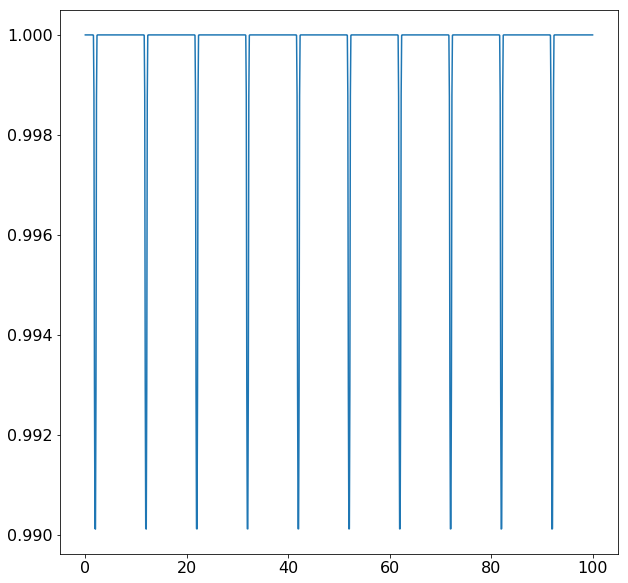

In [243]:
plt.plot(time,y)
# plt.plot(fold(time,p),f,'.')

In [271]:
# %%time
# # do this in terms of epochs
# nt = np.size(time)
# nepochs = 1000
# ndur = 10
# X = np.zeros((nt,nepochs*ndur+1+nt))
# sample = 20
# dummy = np.linspace(time.min(),time.max(),nt*sample)

# epochs = time.max()*np.linspace(0.,1.,nepochs)
# durations = np.linspace(duration*0.9,duration*1.1,ndur)

# for j, ep in enumerate(epochs):
#     for k, dur in enumerate(durations):
#         X[:,j] = 0. - downscale_local_mean(supergauss(dummy,ep,dur),(sample,))
    
# for j in range(nt):
#     X[j,nepochs*ndur+j] = 1.
    
# X[:,-1] = 1.

CPU times: user 6.44 s, sys: 58.9 ms, total: 6.5 s
Wall time: 6.5 s


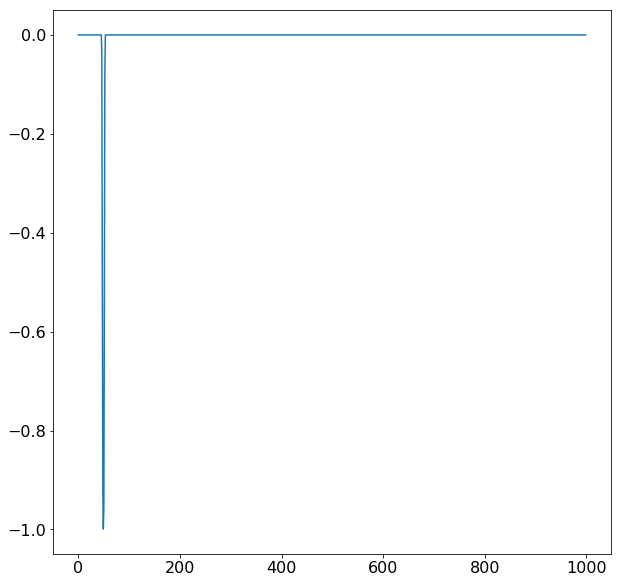

In [272]:
plt.plot(X[:,50])

### For basis pursuit: 
https://github.com/drrelyea/SPGL1_python_port 

### minimize ||x||_1 subject to Ax = b




In [273]:
%%time
x,resid,grad,info = spg_bp(X, y)

CPU times: user 13.4 s, sys: 96.3 ms, total: 13.5 s
Wall time: 4.24 s


In [274]:
sim = np.dot(X,x)

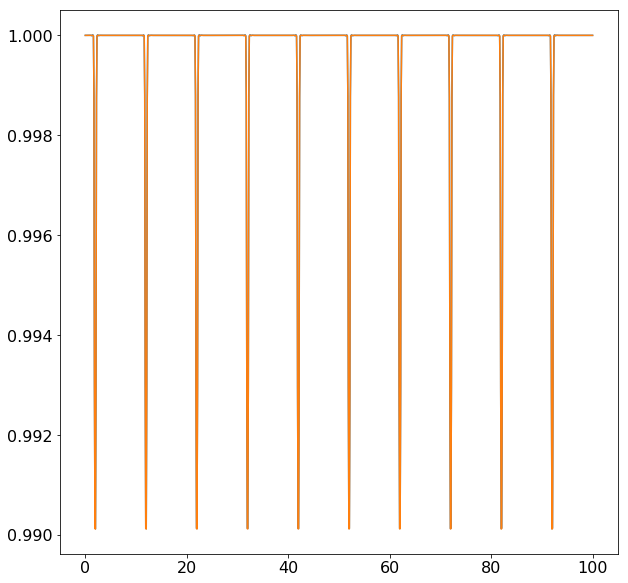

In [275]:
plt.plot(time,sim)
plt.plot(time,y)

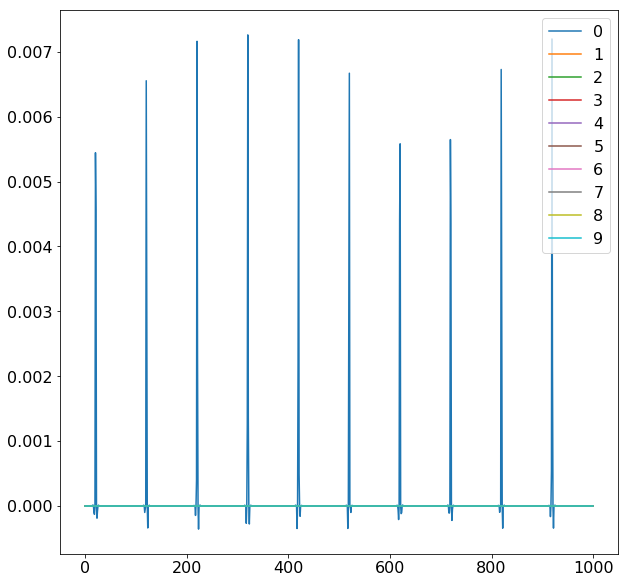

In [281]:
for j in range(ndur):
    plt.plot(x[nepochs*j:nepochs*(j+1)],label=j)
plt.legend()

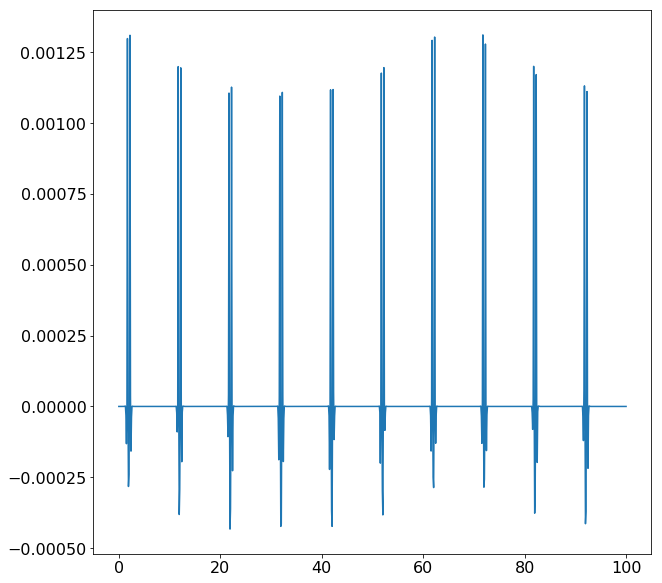

In [282]:
plt.plot(time,x[nepochs*ndur:nepochs*ndur+nt])

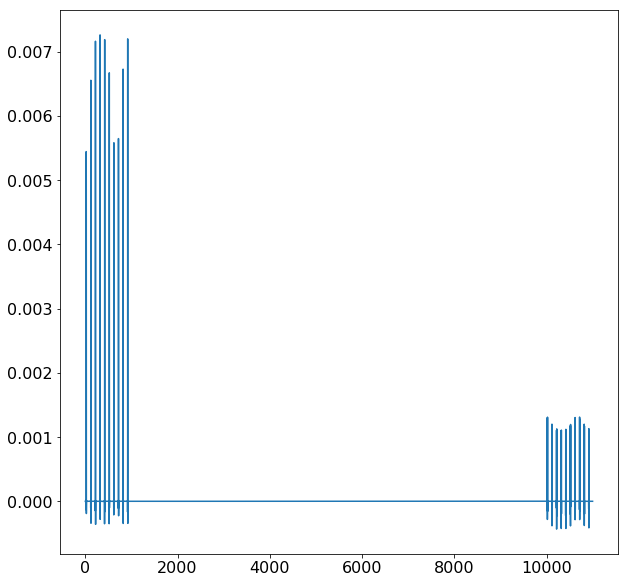

In [283]:
plt.plot(x[:-1])

## Now do it in terms of periods

In [330]:
%%time
# do this in terms of periods
nt = np.size(time)
nepochs = 50
nperiods = 1000
X = np.zeros((nt,nepochs*nperiods+1+nt))
sample = 20
dummy = np.linspace(time.min(),time.max(),nt*sample)

epochs = np.linspace(0.,1.,nepochs)
periods = np.linspace(8.,12,nperiods)

for j, per in enumerate(periods):
    for k, ep in enumerate(epochs):
        X[:,j*k] = 0. - downscale_local_mean(supergauss((dummy % per)/per,ep,duration/per),(sample,))
    
for j in range(nt):
    X[j,nepochs*nperiods+j] = 1.
    
X[:,-1] = 1.

CPU times: user 50.3 s, sys: 660 ms, total: 50.9 s
Wall time: 51.2 s


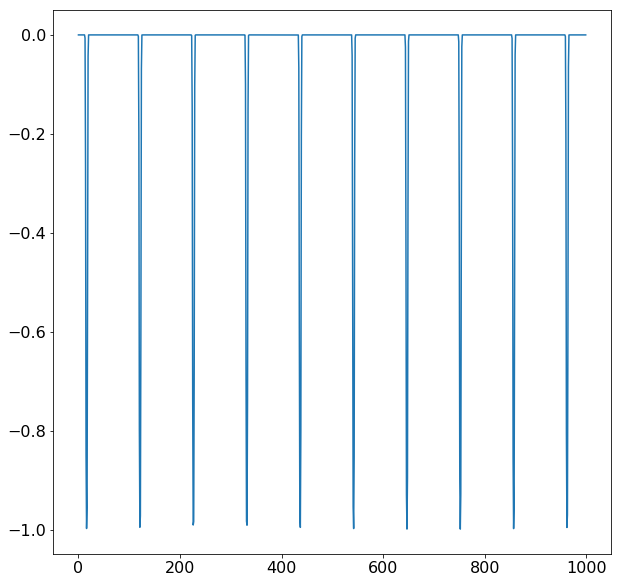

In [331]:
plt.plot(X[:,5000])

In [332]:
%%time
x,resid,grad,info = spg_bp(X, y)

CPU times: user 13min 43s, sys: 6.67 s, total: 13min 50s
Wall time: 4min 27s


In [333]:
sim = np.dot(X,x)

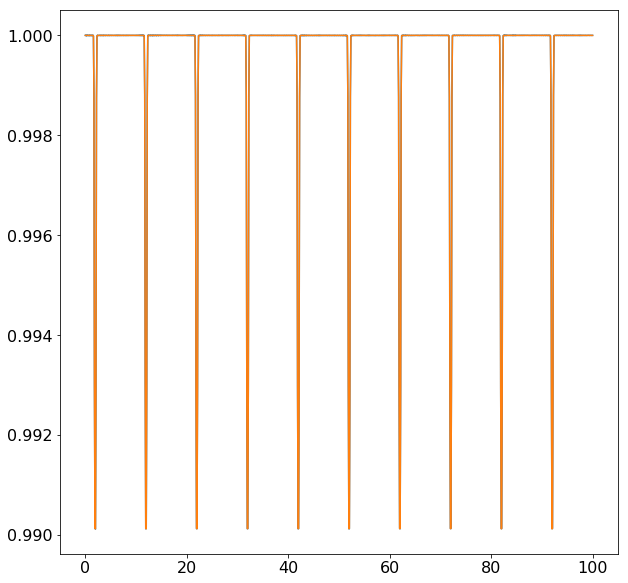

In [343]:
plt.plot(time,sim)
plt.plot(time,y)

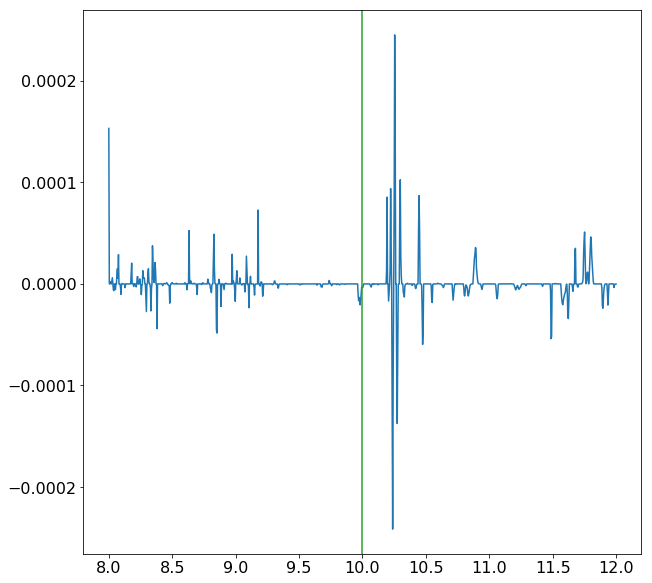

In [335]:
plt.plot(periods,x[:nperiods])
plt.axvline(period,color=colours[2])

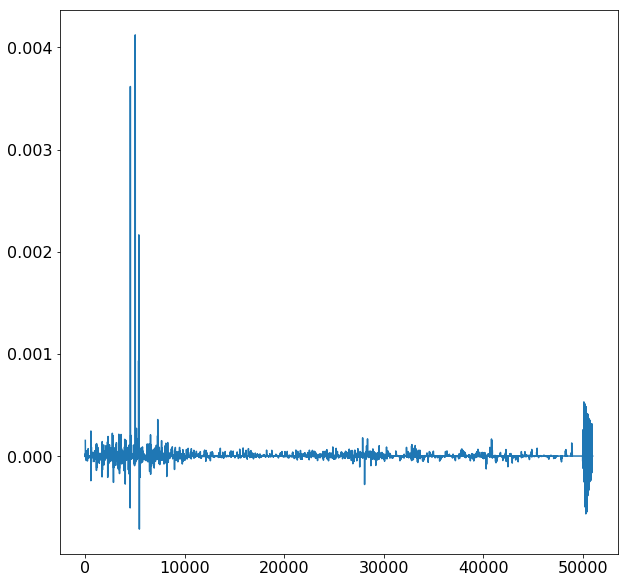

In [349]:
plt.plot(x[:-1])


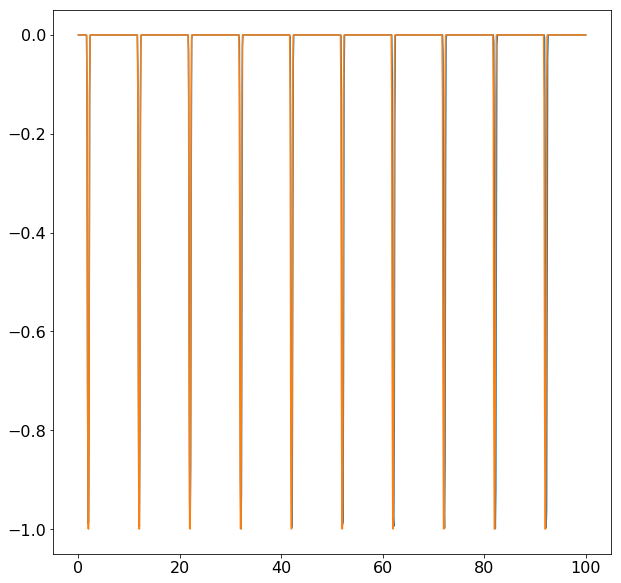

In [348]:
plt.plot(time,X[:,np.argmax(x[:-1])])
plt.plot(time,(1-y)/(y-1).min())